### Quản lý tham số
- Một khi ta đã chọn được kiến trúc mạng và các giá trị siêu tham số, ta bắt đầu với vòng lặp huấn luyện với mục tiêu là tìm các giá trị tham số để cực tiểu hóa hàm mục tiêu. 
- Sau khi huấn luyện xong, ta sẽ cần các tham số đps để đưa ra dự đoán trong tương lai.
- Ta có thể sẽ muốn trích xuất tham số đó để sử dụng lại trong một hoàn cảnh khác, có thể lưu trữ mô hình để thực thi trong một phần mềm khác hoặc để rút ra hiểu biết khoa học bằng việc phân tích mô hình.
- Thông thường, ta có thể bỏ qua những chi tiết chuyên sâu về việc khai báo và xử lý vì Gluon sẽ xử lý công việc này. Tuy nhiên , khi ta bắt đầu tiến xa hơn những kiến trúc chỉ gồm các tầng tiêu chuẩn được xếp chồng lên nhau, đôi khi ta sẽ phải tự đi sâu vào việc khai báo và xử lý tham số. Trong mục này, ta sẽ làm những công việc sau:
    1. Truy cập các tham số để gỡ lỗi, chẩn đoán mô hình và biểu diễn trực quan
    2. Khởi tạo tham số
    3. Chia sẻ tham số giữa các thành phần khác nhau của mô hình
- Xét mạng MLP 1 tầng ẩn

In [12]:
from mxnet import init, np, npx
from mxnet.gluon import nn
npx.set_np()

In [13]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'))
net.add(nn.Dense(10))
net.initialize()

x = np.random.uniform(size = (2, 20))
net(x)

array([[ 0.04084709, -0.00071239,  0.02014565,  0.02236653,  0.00472507,
         0.04849368,  0.08214624, -0.0164523 , -0.04526277, -0.00610431],
       [ 0.02106806,  0.03468598, -0.0208749 ,  0.01669128,  0.02342112,
         0.02198544,  0.05245818,  0.0103803 ,  0.00019757, -0.00864373]])

#### Truy cập tham số
- Khi một mô hình được định nghĩa bằng lớp Tuần tự, ta có thể truy cập bất kỳ tầng nào bằng chỉ số, như thể nó là một danh sách. 
- Thuộc tính params của môi tầng chứa tham số của chúng.

In [14]:
print(net[0].params)
print(net[1].params)

dense4_ (
  Parameter dense4_weight (shape=(256, 20), dtype=float32)
  Parameter dense4_bias (shape=(256,), dtype=float32)
)
dense5_ (
  Parameter dense5_weight (shape=(10, 256), dtype=float32)
  Parameter dense5_bias (shape=(10,), dtype=float32)
)


- Kết quả của đoạn mã này cho ta một vài thông tin quan trọng. Đầu tiên, mỗi tầng kết nối đầy đủ đều có hai tập tham số, ví dụ như dense_weight và dense_bias tương ứng với trọng số và hệ số điều chỉnh của tầng đó. Chúng đều được lưu trữ ở dạng số thực dấu phẩy động.
- Lưu ý rằng tên của các tham số cho phép ta xác định tham số của từng tầng một một cách động nhất, kể cả khi mạng nơ ron chứa hàng trăm tầng.

#### Các tham số Mục tiêu
- Lưu ý rằng mỗi tham số được biểu diễn bằng một thực thể của lớp Parameter. Để làm việc với các tham số, trước hết ta phải truy cập được các giá trị số của chúng. 
- Để bắt đầu, ta có thể truy cập tham số của một tầng thông qua thuộc tính bias hoặc weight rồi sau đó truy cập giá trị số của chúng thông qua phương thức data(). 
- Đoạn mã dưới đây trích xuất hệ số điều chỉnh của tầng thứ hai trong mạng nơ ron.

In [15]:
print(net[1].bias)
print(net[1].bias.data())

Parameter dense5_bias (shape=(10,), dtype=float32)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


- Tham số là các đối tượng khá phức tạp bởi chúng chứa dữ liệu, gradient và một vài thông tin khác. Đó là lý do tại sao ta cần yêu cầu dữ liệu một cách tường minh. Lưu ý rằng vector hệ số điều chỉnh chứa các giá trị không vì ta chưa hề cập nhật mô hình kể từ khi nó được khởi tạo.
- Ta cũng có thể truy cập các tham số theo tên của chúng, chẳng hạn như dense16_weight. Điều này khả thi vì thực ra mỗi tầng đều chứa một từ điển tham số.

In [16]:
# print(net[0].params['dense16_weight'])
# print(net[0].params['dense16_weight'].data())

- Khác với hệ số điều chỉnh, trọng số của chứa các giá trị khác 0 là bởi chúng được khởi tạo ngẫu nhiên.
- Ngoài data, mỗi __Parameter__ còn cung cấp phương thức __grad()__ để truy cập gradient. Gradient sẽ có cùng kích thước trọng số. Vì ta chưa thực hiện lan truyền ngược với mạng nơ ron này, các giá trị của gradient sẽ là 0.

In [17]:
net[0].weight.grad()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Truy cập Tất cả các tham số cùng lúc
- Khi ta cần phải thực hiện các phép toán với tất cả các tham số, việc truy cập lần lượt từng tham số sẽ trở nên khá khó chịu. Việc này sẽ càng chậm chạp hơn khi ta làm việc với các khổi phức tạo hơn, ví dụ như các khối lồng nhau vì lúc đó ta sẽ phải duyệt toàn bộ cây bằng đệ quy để có thể trích xuất tham số của từng khối con.
- Để tránh vấn đề này, mỗi khối đều có thêm một phương thức collect_params để trả về một từ điển duy nhất chứa tất cả tham số. Ta có thể gọi collect_params với một tầng duy nhất hoặc với toàn bộ mạng nơ ron như sau:

In [18]:
print(net)
print(net.collect_params())
print(net[0].collect_params())

Sequential(
  (0): Dense(20 -> 256, Activation(relu))
  (1): Dense(256 -> 10, linear)
)
sequential2_ (
  Parameter dense4_weight (shape=(256, 20), dtype=float32)
  Parameter dense4_bias (shape=(256,), dtype=float32)
  Parameter dense5_weight (shape=(10, 256), dtype=float32)
  Parameter dense5_bias (shape=(10,), dtype=float32)
)
dense4_ (
  Parameter dense4_weight (shape=(256, 20), dtype=float32)
  Parameter dense4_bias (shape=(256,), dtype=float32)
)


Khối Sequential chỉ đơn thuần đánh số cho các khối con, ta có thể tận dụng quy ước định danh này với một tính năng của __collect_params__ để lọc ra các tham số được trả về bằng các biểu thức chính quy.

In [19]:
print(net.collect_params('.*weight'))
print(net.collect_params("dense16.*"))

sequential2_ (
  Parameter dense4_weight (shape=(256, 20), dtype=float32)
  Parameter dense5_weight (shape=(10, 256), dtype=float32)
)
sequential2_ (

)


#### Thu thập tham số từ các khổi lồng nhau

In [20]:
def block1():
    net = nn.Sequential()
    net.add(nn.Dense(32, activation='relu'))
    net.add(nn.Dense(16, activation='relu'))
    return net

def block2():
    net = nn.Sequential()
    for i in range(4):
        net.add(block1())
    return net

rgnet = nn.Sequential()
rgnet.add(block2())
rgnet.add(nn.Dense(10))
rgnet.initialize()
rgnet(x)


array([[ 8.91532714e-09,  1.63008274e-10, -7.03773662e-09,
        -7.03023151e-09,  7.37013073e-09, -6.20238261e-09,
         1.17877219e-08, -1.15572893e-08,  6.61574129e-09,
        -1.29038042e-08],
       [ 1.08686056e-08, -1.83620141e-09, -2.03574801e-09,
        -2.66009592e-09,  4.72659423e-09, -4.86795582e-09,
         8.57475779e-09, -1.16852128e-08,  5.29565014e-09,
        -1.00744675e-08]])

- Giờ ta đã xong phần thiết kế mạng, hãy xem cách nó được tổ chức, để ý rằng dù hàm __collect_params()__ trả về một danh sách các tham số được định danh, việc gọi __collect_params__ như một thuộc tính sẽ cho ta biết cấu trúc của mạng.

In [21]:
print(rgnet)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Dense(20 -> 32, Activation(relu))
      (1): Dense(32 -> 16, Activation(relu))
    )
    (1): Sequential(
      (0): Dense(16 -> 32, Activation(relu))
      (1): Dense(32 -> 16, Activation(relu))
    )
    (2): Sequential(
      (0): Dense(16 -> 32, Activation(relu))
      (1): Dense(32 -> 16, Activation(relu))
    )
    (3): Sequential(
      (0): Dense(16 -> 32, Activation(relu))
      (1): Dense(32 -> 16, Activation(relu))
    )
  )
  (1): Dense(16 -> 10, linear)
)


In [22]:
print(rgnet.collect_params)

<bound method Block.collect_params of Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Dense(20 -> 32, Activation(relu))
      (1): Dense(32 -> 16, Activation(relu))
    )
    (1): Sequential(
      (0): Dense(16 -> 32, Activation(relu))
      (1): Dense(32 -> 16, Activation(relu))
    )
    (2): Sequential(
      (0): Dense(16 -> 32, Activation(relu))
      (1): Dense(32 -> 16, Activation(relu))
    )
    (3): Sequential(
      (0): Dense(16 -> 32, Activation(relu))
      (1): Dense(32 -> 16, Activation(relu))
    )
  )
  (1): Dense(16 -> 10, linear)
)>


In [23]:
print(rgnet.collect_params())

sequential3_ (
  Parameter dense6_weight (shape=(32, 20), dtype=float32)
  Parameter dense6_bias (shape=(32,), dtype=float32)
  Parameter dense7_weight (shape=(16, 32), dtype=float32)
  Parameter dense7_bias (shape=(16,), dtype=float32)
  Parameter dense8_weight (shape=(32, 16), dtype=float32)
  Parameter dense8_bias (shape=(32,), dtype=float32)
  Parameter dense9_weight (shape=(16, 32), dtype=float32)
  Parameter dense9_bias (shape=(16,), dtype=float32)
  Parameter dense10_weight (shape=(32, 16), dtype=float32)
  Parameter dense10_bias (shape=(32,), dtype=float32)
  Parameter dense11_weight (shape=(16, 32), dtype=float32)
  Parameter dense11_bias (shape=(16,), dtype=float32)
  Parameter dense12_weight (shape=(32, 16), dtype=float32)
  Parameter dense12_bias (shape=(32,), dtype=float32)
  Parameter dense13_weight (shape=(16, 32), dtype=float32)
  Parameter dense13_bias (shape=(16,), dtype=float32)
  Parameter dense14_weight (shape=(10, 16), dtype=float32)
  Parameter dense14_bias (shap

Bởi vì các tầng được lồng vào nhau theo cơ chế phân cấp, ta cũng có thể truy cập chúng tương tự như các ta dùng chỉ số để truy cập các danh sách lồng nhau. Chẳng hạn, ta có  thể truy cập khối chính đàu tiên, khối con thứ hai bên trong nó và hệ số điều chỉnh của tầng đầu tiên bên trong nữa như sau:

In [24]:
rgnet[0][1][0].bias.data()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Khởi tạo tham số
- Theo mặc định MXNet khởi tạo các ma trận trọng số bằng cách lấy mẫu từ phân phối đều U[-0.07, 0.07] và đặt tất cả các hệ số điều chỉnh bằng 0. Tuy nhiên, thường ta sẽ muốn khởi tạo trọng số theo nhiều phương pháp khác. Module MXNet cung cấp sẵn nhiều phương thức khởi tạo.

#### 1. Phương thức khởi tạo có sẵn
- Đoạn mã dưới đây khởi tạo tất cả các tham số với các biến ngẫu nhiên Gauss có độ lệch chuẩn bằng 0.01.

In [28]:
# force_reinit ensure that variables are freshly initialized even if they were
# already initialized previously
net.initialize(init = init.Normal(sigma=0.01), force_reinit=True)
net[0].weight.data()[0]

array([-0.00549284, -0.00559499,  0.01482466,  0.0026227 , -0.01958737,
       -0.0077996 ,  0.01513424,  0.00679269, -0.01309387, -0.00230433,
        0.00022414,  0.00440715, -0.01279781, -0.00457279, -0.01067273,
       -0.0129427 ,  0.01370852, -0.0032856 ,  0.00122968,  0.00280137])

- Ta cũng có thể khởi tạo tất cả tham số với một hằng số bằng cách sử dụng bộ khởi tạo __Constant(1)__

In [31]:
net.initialize(init = init.Constant(1), force_reinit=True)
net[0].weight.data()[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

- Ta còn có thể áp dụng các bộ khởi tạo khác nhau cho các khối khác nhau. Ví dụ, trong đoạn mã nguồn bên dưới, ta khởi tạo tầng đầu tiên bằng cách sử dụng bộ khởi tạo Xavier và khởi tạo tầng thứ hai với một hằng số là 42.

In [34]:
net[0].weight.initialize(init = init.Xavier(), force_reinit = True)
net[1].initialize(init = init.Constant(123), force_reinit=True)

#### 2.Phương thức khởi tạo tùy chỉnh
- Đôi khi, các phương thức khởi tạo mà ta cần không có sẵn trong module init. Trong trường hợp đó, ta có thể khai báo một lớp con của lớp __Initializer__. Thông thường, ta chỉ cần lập trình cho hàm ___init_weight__ để nhận một đối số ndarray(data) và gán giá trị khởi tạo mong muốn cho nó.
- Ví dụ, ta cần khai báo một bộ khởi tạo cho phân phối sau:

    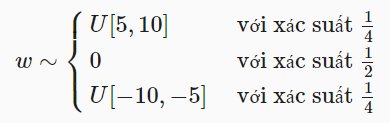

In [35]:
class MyInit(init.Initializer):
    def _init_weight(self, name, data):
        print('Init', name, data.shape)
        data[:] = np.random.uniform(-10, 10, data.shape)
        data *= np.abs(data) >= 5

net.initialize(init = MyInit(), force_reinit=True)
net[0].weight.data()

Init dense4_weight (256, 20)
Init dense5_weight (10, 256)


array([[-6.410269 ,  0.       , -0.       , ...,  8.440153 , -5.1620936,
         6.037012 ],
       [-9.018925 , -0.       , -8.321178 , ..., -0.       ,  8.692524 ,
        -5.5963187],
       [-0.       ,  0.       , -0.       , ...,  0.       ,  0.       ,
        -0.       ],
       ...,
       [-6.8447447,  7.3555317,  0.       , ...,  9.02512  , -0.       ,
        -0.       ],
       [ 5.431259 , -5.689399 ,  0.       , ...,  6.0531826,  0.       ,
         8.389328 ],
       [ 7.187292 ,  7.7677174, -9.803394 , ..., -7.509557 , -0.       ,
        -5.5423656]])

- Lưu ý rằng ta luôn có thể đặt trực tiếp giá trị cho tham số bằng cách gọi hàm data() để truy cập ndarray của tham số đó. 
- __Nếu muốn điều chỉnh các tham số trong phạm vi của autograd, ta cần sử dụng hàm set_data để tránh làm rồi loạn cơ chế tính vi phân tự động.__

In [37]:
net[0].weight.data()[:] += 1
net[0].weight.data()[0, 0] = 42
net[0].weight.data()[0]

array([42.       ,  2.       ,  2.       ,  2.       , 11.302258 ,
        2.       , 11.808821 , -3.9286432, -6.82191  , -5.0909166,
       11.116852 , -4.194465 ,  2.       ,  9.472414 ,  2.       ,
        8.601463 ,  2.       , 10.440153 , -3.1620936,  8.037012 ])

#### 3. Các tham số bị trói buộc
- Thông thường, ta sẽ muốn chia sẻ các tham số mô hình cho nhiều tầng. Sau này ta sẽ thấy trong quá trình huấn luyện embedding từ, việc sử dụng cùng một bộ tham số để mã hóa và giải mã các từ có thể khá hợp lý.
- Sau đây, ta sẽ tạo một tầng kết nối đầy đủ và sử dụng chính tham số của nó làm tham số cho một tầng khác.

In [38]:
net = nn.Sequential()
# We  need to give the shared layer a name such that we can reference its parameters
shared = nn.Dense(8, activation='relu')
net.add(nn.Dense(8, activation='relu'),
        shared,
        nn.Dense(8, activation='relu', params = shared.params),
        nn.Dense(10)
        )
net.initialize()

x = np.random.uniform(size = (2, 20))
net(x)

# Check whether the parameters are the same
print(net[1].weight.data() == net[2].weight.data())
net[1].weight.data()[:] = 100

print(net[1].weight.data() == net[2].weight.data())



[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]]
[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]]


- Ví dụ này cho thấy các tham số của tầng thứ hai và tầng thứ ba đã bị trói buộc với nhau. Chúng không chỉ có giá trị bằng nhau, chúng còn được biểu diễn bởi cùng một ndarray. Vì vậy, nếu ta thay đổi các tham số của tầng này thì tham số của tầng kia cũng sẽ thay đổi theo.